<a href="https://colab.research.google.com/github/lukechang93-ucla/MAE-263F/blob/main/proposal/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LINEAR

Modified MAE_263F code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

#  USER-EDITABLE PARAMETERS =============================================================================================================================================================================================
#  MODEL OPTION
USE_NONLINEAR_ES = False  # True = use stress-strain table; False = linear EA

#  IMPERIAL INPUTS (geometry, material)
# Geometry (inches)
NX_CELLS       = 3      # macro square cells in x
NY_CELLS       = 3      # macro square cells in y
NODES_PER_EDGE = 3      # segments per macro edge (>=1), along edges only
LX_in = 0.5            # overall width in inches
LY_in = 0.5            # overall height in inches

# Material properties (density & E)
RHO_lbft3     = 78.0    # ~1250 kg/m^3 for TPU
YOUNG_MOD_psi = 1.0e4   # ~67 MPa

# Total mass of the entire structure (drives cross-section radius)
TOTAL_MASS_LBM = 0.001    # lbm

# Loads (lbf)
LOAD_TOTAL_Y_LBF = -0.01   # total vertical load applied to selected nodes
LOAD_TOTAL_X_LBF = 0.0

# Time integration (seconds)
DT            = 0.0002
TOTAL_TIME    = 0.2        # simulate to 0.15 s
LOAD_DURATION = 0.1375        # load active for t < 0.10 s
MAX_NEWTON_ITERS  = 5000
NEWTON_TOL_FACTOR = 1e-3

# Damping
DAMPING_COEFF = 0.003      # N·s/m (SI)

# Loading pattern toggles
LOAD_TOP_ROW    = True
LOAD_BOTTOM_ROW = False
LOAD_LEFT_COL   = False
LOAD_RIGHT_COL  = False
LOAD_TOP_ROW_CENTER_ONLY = True
TOP_ROW_CENTER_COUNT     = 10
USE_CUSTOM_LOAD_NODES    = False
CUSTOM_LOAD_NODE_INDICES = []   # e.g.[37, 38, 39]

# Fixed (clamped) nodes
FIX_BOTTOM_ROW = True
FIX_TOP_ROW    = False
FIX_LEFT_COL   = False
FIX_RIGHT_COL  = False

# Plotting / tracking
PLOT_STEP = 1          # 1 = plot every step
TRACK_NODE_INDEX = -1  # -1 => auto top-center
PLOT_CENTER_HISTORY = True
PLOT_ENERGY_HISTORY = True

# Collision handling
ENABLE_COLLISIONS          = True
COLLISION_RADIUS_FRACTION  = 0.5
COLLISION_ITERS            = 5

# Vertical ordering constraint
ENABLE_VERTICAL_ORDER_CONSTRAINT = True
VERTICAL_GAP_FRACTION           = 0.0  # 0 = touching allowed

# Newton regularization
REG_EPS = 1e-8

# Stiffness scaling (dimensionless)
EI_SCALE  = 1.0
EA_SCALE  = 1.0  # used only in linear mode

#  VIDEO / OUTPUT MODE OPTIONS
# OUTPUT_MODE:
#   "LIVE"  -> live animation only
#   "VIDEO" -> live animation + MP4 recording
#   "NONE"  -> no per-step plotting during simulation
OUTPUT_MODE    = "VIDEO"          # "LIVE", "VIDEO", or "NONE"
VIDEO_FILENAME = "simulation.mp4"
VIDEO_FPS      = 30              # frames per second if VIDEO

#  IMPERIAL → METRIC CONVERSIONS =============================================================================================================================================================================================
IN_TO_M       = 0.0254
FT_TO_M       = 0.3048
PSI_TO_PA     = 6894.757293168361
LBFT3_TO_KGM3 = 16.01846337396014
LBF_TO_N      = 4.4482216152605
LBM_TO_KG     = 0.45359237
# Geometry in meters
LX = LX_in * IN_TO_M
LY = LY_in * IN_TO_M
# Material in SI
RHO       = RHO_lbft3 * LBFT3_TO_KGM3
YOUNG_MOD = YOUNG_MOD_psi * PSI_TO_PA
# Total mass in SI
TOTAL_MASS = TOTAL_MASS_LBM * LBM_TO_KG
# Loads in SI
LOAD_TOTAL_Y = LOAD_TOTAL_Y_LBF * LBF_TO_N
LOAD_TOTAL_X = LOAD_TOTAL_X_LBF * LBF_TO_N

#  UTILITY =============================================================================================================================================================================================
def crossMat(a):
    return np.array([
        [0.0,     -a[2],  a[1]],
        [a[2],  0.0,    -a[0]],
        [-a[1],  a[0],  0.0 ]
    ])


#  BENDING =============================================================================================================================================================================================

def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,   yk,   0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1

    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    EPS_LEN = 1e-12
    if norm_e < EPS_LEN or norm_f < EPS_LEN:
        return np.zeros(6)

    te = ee / norm_e
    tf = ef / norm_f

    dot_te_tf = np.dot(te, tf)
    dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    chi = 1.0 + dot_te_tf
    kb = 2.0 * np.cross(te, tf) / chi

    tilde_t  = (te  + tf ) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]

    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k
    return dF

def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,   yk,   0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1

    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    EPS_LEN = 1e-12
    if norm_e < EPS_LEN or norm_f < EPS_LEN:
        return np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    te = ee / norm_e
    tf = ef / norm_f

    dot_te_tf = np.dot(te, tf)
    dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    chi = 1.0 + dot_te_tf
    kb = 2.0 * np.cross(te, tf) / chi

    tilde_t  = (te  + tf ) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]

    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    DDkappa1 = np.zeros((6, 6))
    Id3 = np.eye(3)

    tt_o_tt = np.outer(tilde_t, tilde_t)

    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)

    kb_o_d2e = np.outer(kb, m2e)
    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e \
                  - kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) \
                  + (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T

    kb_o_d2f = np.outer(kb, m2f)
    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f \
                  - kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) \
                  + (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)

    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                   + 1.0 / (norm_e * norm_f) * (
                       2 * kappa1 * tt_o_tt
                       - tf_c_d2t_o_tt
                       + tt_o_te_c_d2t
                       - crossMat(tilde_d2)
                   )
    D2kappa1DfDe = D2kappa1DeDf.T

    DDkappa1[0:2, 0:2] =  D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]

    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] =  D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] \
                          - D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] =  D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]

    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] =  D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] =  D2kappa1Df2[0:2, 0:2]

    dkappa = kappa1 - kappaBar
    dJ = (EI / l_k) * np.outer(gradKappa, gradKappa)
    dJ += (EI * dkappa / l_k) * DDkappa1
    return dJ

# STRETCHING - LINEAR =============================================================================================================================================================================================

def gradEs_linear(xk, yk, xkp1, ykp1, l_k, EA):
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = np.sqrt(dx*dx + dy*dy)

    if L == 0.0:
        return np.zeros(4)

    dEdL = EA / l_k * (L - l_k)

    dLdx0 = -dx / L
    dLdy0 = -dy / L
    dLdx1 =  dx / L
    dLdy1 =  dy / L

    F = np.zeros(4)
    F[0] = dEdL * dLdx0
    F[1] = dEdL * dLdy0
    F[2] = dEdL * dLdx1
    F[3] = dEdL * dLdy1
    return F

def hessEs_linear(xk, yk, xkp1, ykp1, l_k, EA):
    x0, y0, x1, y1 = xk, yk, xkp1, ykp1
    dx = x1 - x0
    dy = y1 - y0
    r2 = dx*dx + dy*dy
    if r2 == 0.0:
        return np.zeros((4, 4))

    L = np.sqrt(r2)
    c = dx / L
    s = dy / L

    k = EA / l_k
    k_local = k * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local

def compute_stretching_energy_linear(q, EA):
    global edges, edge_rest
    Es = 0.0
    for (i, j) in edges:
        x0, y0 = q[2*i],   q[2*i + 1]
        x1, y1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]
        dx = x1 - x0
        dy = y1 - y0
        L  = math.hypot(dx, dy)
        Es += 0.5 * EA / l0 * (L - l0)**2
    return Es

# STRETCHING - NONLINEAR =============================================================================================================================================================================================

# Literature-based TPU curve (strain in %, stress in MPa)
strain_raw = np.array([
    0.225, 0.770, 1.314, 1.859, 2.404,
    2.949, 3.493, 4.038, 4.583, 5.128,
    5.673, 6.218, 6.762, 7.307, 7.852,
    8.397, 8.942, 9.486, 10.031, 10.576
])
stress_raw_MPa = np.array([
    0.172, 2.308, 3.329, 3.987, 4.570,
    5.313, 6.099, 6.877, 7.636, 8.754,
    9.840, 10.960, 12.600, 14.400, 16.300,
    18.500, 21.000, 23.700, 26.200, 29.100
])

# Convert to engineering strain (fraction) and stress in Pa
eps_tab = np.concatenate(([0.0], strain_raw / 100.0))
sig_tab = np.concatenate(([0.0], stress_raw_MPa * 1e6))

psi_tab = np.zeros_like(eps_tab)
for i in range(1, len(eps_tab)):
    de = eps_tab[i] - eps_tab[i-1]
    psi_tab[i] = psi_tab[i-1] + 0.5 * (sig_tab[i] + sig_tab[i-1]) * de

def stress_tangent_from_table(eps):
    if eps <= eps_tab[0]:
        e0, e1 = eps_tab[0], eps_tab[1]
        s0, s1 = sig_tab[0], sig_tab[1]
        if e1 == e0:
            return s0, 0.0
        slope = (s1 - s0) / (e1 - e0)
        sigma = s0 + slope * (eps - e0)
        return sigma, slope

    if eps >= eps_tab[-1]:
        e0, e1 = eps_tab[-2], eps_tab[-1]
        s0, s1 = sig_tab[-2], sig_tab[-1]
        if e1 == e0:
            return s1, 0.0
        slope = (s1 - s0) / (e1 - e0)
        sigma = s1 + slope * (eps - e1)
        return sigma, slope

    i = np.searchsorted(eps_tab, eps) - 1
    e0, e1 = eps_tab[i],   eps_tab[i+1]
    s0, s1 = sig_tab[i],   sig_tab[i+1]

    if e1 == e0:
        return s0, 0.0

    t = (eps - e0) / (e1 - e0)
    sigma = (1.0 - t) * s0 + t * s1
    Et    = (s1 - s0) / (e1 - e0)
    return sigma, Et

def energy_density_from_table(eps):
    if eps <= eps_tab[0]:
        e0, e1 = eps_tab[0], eps_tab[1]
        s0, s1 = sig_tab[0], sig_tab[1]
        if e1 == e0:
            return 0.0
        slope = (s1 - s0) / (e1 - e0)
        return 0.5 * slope * eps**2

    if eps >= eps_tab[-1]:
        psi_last = psi_tab[-1]
        e0, e1 = eps_tab[-2], eps_tab[-1]
        s0, s1 = sig_tab[-2], sig_tab[-1]
        if e1 == e0:
            return psi_last
        slope = (s1 - s0) / (e1 - e0)
        de = eps - e1
        extra = s1 * de + 0.5 * slope * de**2
        return psi_last + extra

    i = np.searchsorted(eps_tab, eps) - 1
    e0, e1 = eps_tab[i],   eps_tab[i+1]
    s0, s1 = sig_tab[i],   sig_tab[i+1]
    psi0   = psi_tab[i]

    if e1 == e0:
        return psi0

    t = (eps - e0) / (e1 - e0)
    s_eps = (1.0 - t) * s0 + t * s1
    de = eps - e0
    psi_eps = psi0 + 0.5 * (s0 + s_eps) * de
    return psi_eps

def gradEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA_unused):
    global A_cross
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = np.sqrt(dx*dx + dy*dy)

    if L == 0.0 or l_k <= 0.0:
        return np.zeros(4)

    eps = (L - l_k) / l_k
    sigma, Et = stress_tangent_from_table(eps)
    N = A_cross * sigma
    dEdL = N

    dLdx0 = -dx / L
    dLdy0 = -dy / L
    dLdx1 =  dx / L
    dLdy1 =  dy / L

    F = np.zeros(4)
    F[0] = dEdL * dLdx0
    F[1] = dEdL * dLdy0
    F[2] = dEdL * dLdx1
    F[3] = dEdL * dLdy1
    return F

def hessEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA_unused):
    global A_cross
    x0, y0, x1, y1 = xk, yk, xkp1, ykp1
    dx = x1 - x0
    dy = y1 - y0
    r2 = dx*dx + dy*dy
    if r2 == 0.0 or l_k <= 0.0:
        return np.zeros((4, 4))

    L = np.sqrt(r2)
    c = dx / L
    s = dy / L

    eps = (L - l_k) / l_k
    sigma, Et = stress_tangent_from_table(eps)
    EA_eff = A_cross * Et
    k = EA_eff / l_k

    k_local = k * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local

def compute_stretching_energy_nonlinear(q, EA_unused):
    global edges, edge_rest, A_cross
    Es = 0.0
    for (i, j) in edges:
        x0, y0 = q[2*i],   q[2*i + 1]
        x1, y1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]

        dx = x1 - x0
        dy = y1 - y0
        L  = math.hypot(dx, dy)
        if l0 <= 0.0:
            continue

        eps = (L - l0) / l0
        psi = energy_density_from_table(eps)
        Es += A_cross * l0 * psi
    return Es


# SWITCHING WRAPPERS =============================================================================================================================================================================================
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    if USE_NONLINEAR_ES:
        return gradEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA)
    else:
        return gradEs_linear(xk, yk, xkp1, ykp1, l_k, EA)

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    if USE_NONLINEAR_ES:
        return hessEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA)
    else:
        return hessEs_linear(xk, yk, xkp1, ykp1, l_k, EA)

def compute_stretching_energy(q, EA):
    if USE_NONLINEAR_ES:
        return compute_stretching_energy_nonlinear(q, EA)
    else:
        return compute_stretching_energy_linear(q, EA)

# GLOBAL ASSEMS =============================================================================================================================================================================================
edges = None
bend_triplets = None
edge_rest = None

def getFs(q, EA):
    global edges, edge_rest
    ndof = q.size
    Fs = np.zeros(ndof)
    Js = np.zeros((ndof, ndof))

    for (i, j) in edges:
        xk,   yk   = q[2*i],   q[2*i + 1]
        xkp1, ykp1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]
        ind = np.array([2*i, 2*i + 1, 2*j, 2*j + 1])

        gradEnergy = gradEs(xk, yk, xkp1, ykp1, l0, EA)
        hessEnergy = hessEs(xk, yk, xkp1, ykp1, l0, EA)

        Fs[ind] -= gradEnergy
        Js[np.ix_(ind, ind)] -= hessEnergy

    return Fs, Js

def getFb(q, EI):
    global bend_triplets, edge_rest
    ndof = q.size
    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    for (i, j, k) in bend_triplets:
        xkm1, ykm1 = q[2*i], q[2*i + 1]
        xk,   yk   = q[2*j], q[2*j + 1]
        xkp1, ykp1 = q[2*k], q[2*k + 1]

        l1 = edge_rest[(min(i, j), max(i, j))]
        l2 = edge_rest[(min(j, k), max(j, k))]
        l_k = 0.5 * (l1 + l2)

        ind = np.array([2*i, 2*i + 1,
                        2*j, 2*j + 1,
                        2*k, 2*k + 1])

        gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, l_k, EI)
        hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, l_k, EI)

        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy

    return Fb, Jb

def compute_bending_energy(q, EI):
    global bend_triplets, edge_rest
    Eb = 0.0
    EPS_LEN = 1e-12

    for (i, j, k) in bend_triplets:
        xkm1, ykm1 = q[2*i], q[2*i + 1]
        xk,   yk   = q[2*j], q[2*j + 1]
        xkp1, ykp1 = q[2*k], q[2*k + 1]

        node0 = np.array([xkm1, ykm1, 0.0])
        node1 = np.array([xk,   yk,   0.0])
        node2 = np.array([xkp1, ykp1, 0.0])

        ee = node1 - node0
        ef = node2 - node1

        norm_e = np.linalg.norm(ee)
        norm_f = np.linalg.norm(ef)
        if norm_e < EPS_LEN or norm_f < EPS_LEN:
            continue

        te = ee / norm_e
        tf = ef / norm_f

        dot_te_tf = np.dot(te, tf)
        dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

        chi = 1.0 + dot_te_tf
        kb = 2.0 * np.cross(te, tf) / chi
        kappa1 = kb[2]

        l1 = edge_rest[(min(i, j), max(i, j))]
        l2 = edge_rest[(min(j, k), max(j, k))]
        l_k = 0.5 * (l1 + l2)

        kappaBar = 0.0
        dkappa = kappa1 - kappaBar
        Eb += 0.5 * EI / l_k * dkappa**2

    return Eb

# CONTACT =============================================================================================================================================================================================
def project_node_collisions(q, R_COLLISION, fixed_nodes, n_iter=5):
    N = len(q) // 2
    R2 = R_COLLISION * R_COLLISION

    for _ in range(n_iter):
        any_penetration = False
        for i in range(N):
            xi = q[2*i]
            yi = q[2*i + 1]
            for j in range(i + 1, N):
                dx = q[2*j] - xi
                dy = q[2*j + 1] - yi
                dist2 = dx*dx + dy*dy
                if dist2 >= R2 or dist2 == 0.0:
                    continue
                dist = math.sqrt(dist2)
                overlap = R_COLLISION - dist
                if overlap <= 0.0:
                    continue
                any_penetration = True
                nx = dx / dist
                ny = dy / dist
                i_fixed = (i in fixed_nodes)
                j_fixed = (j in fixed_nodes)
                if not i_fixed and not j_fixed:
                    shift = 0.5 * overlap
                    q[2*i]     -= nx * shift
                    q[2*i + 1] -= ny * shift
                    q[2*j]     += nx * shift
                    q[2*j + 1] += ny * shift
                elif i_fixed and not j_fixed:
                    shift = overlap
                    q[2*j]     += nx * shift
                    q[2*j + 1] += ny * shift
                elif j_fixed and not i_fixed:
                    shift = overlap
                    q[2*i]     -= nx * shift
                    q[2*i + 1] -= ny * shift
        if not any_penetration:
            break
    return q

def project_vertical_order(q, vertical_pairs, vertical_gaps, fixed_nodes, n_iter=3):
    Npairs = len(vertical_pairs)
    if Npairs == 0:
        return q

    for _ in range(n_iter):
        any_violation = False
        for k in range(Npairs):
            lower, upper = vertical_pairs[k]
            gap = vertical_gaps[k]
            yL = q[2*lower + 1]
            yU = q[2*upper + 1]
            min_allowed = yL + gap
            if yU >= min_allowed:
                continue
            any_violation = True
            delta = min_allowed - yU
            lower_fixed = (lower in fixed_nodes)
            upper_fixed = (upper in fixed_nodes)
            if not lower_fixed and not upper_fixed:
                shift = 0.5 * delta
                q[2*lower + 1] -= shift
                q[2*upper + 1] += shift
            elif lower_fixed and not upper_fixed:
                q[2*upper + 1] += delta
            elif upper_fixed and not lower_fixed:
                q[2*lower + 1] -= delta
        if not any_violation:
            break
    return q

# TIME STEP OBJECTIVE FUNCTION =============================================================================================================================================================================================

def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat,
           EI, EA,
           W, C, P,
           free_index):
    q_new = q_old.copy()

    iter_count = 0
    error = tol * 10.0
    flag = 1

    stiff_scale = max(EI, EA) if max(EI, EA) > 0 else 1.0
    eps = REG_EPS * stiff_scale

    while error > tol:
        F_inertia = m / dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt**2

        Fs, Js = getFs(q_new, EA)
        Fb, Jb = getFb(q_new, EI)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        v_new = (q_new - q_old) / dt
        Fv = -C @ v_new
        Jv = -C / dt

        f = F_inertia - F_elastic - Fv - W - P
        J = J_inertia - J_elastic - Jv

        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        J_free_reg = J_free + eps * np.eye(J_free.shape[0])

        dq_free = np.linalg.solve(J_free_reg, f_free)
        q_new[free_index] -= dq_free

        error = np.linalg.norm(f_free)
        iter_count += 1

        if iter_count > maximum_iter:
            flag = -1
            print("Maximum Newton iterations reached.")
            return q_new, flag

    return q_new, flag

# MAIN =============================================================================================================================================================================================

# Build macro corners & refine edges with node dedup
hx = LX / NX_CELLS
hy = LY / NY_CELLS

nodes = []
node_map = {}
corner_idx = np.zeros((NY_CELLS + 1, NX_CELLS + 1), dtype=int)
coord_tol = 1e-9 * max(LX, LY) + 1e-12

def get_or_add_node(pos, nodes, node_map, tol):
    x, y = pos
    key = (round(x / tol) * tol, round(y / tol) * tol)
    if key in node_map:
        return node_map[key]
    idx = len(nodes)
    nodes.append([x, y])
    node_map[key] = idx
    return idx

for j in range(NY_CELLS + 1):
    for i in range(NX_CELLS + 1):
        x = i * hx
        y = j * hy
        idx = get_or_add_node((x, y), nodes, node_map, coord_tol)
        corner_idx[j, i] = idx

def subdivide_edge(i0, i1, n_seg, nodes, node_map, edges, bend_triplets, tol):
    p0 = np.array(nodes[i0])
    p1 = np.array(nodes[i1])
    chain = [i0]
    for s in range(1, n_seg):
        t = s / n_seg
        pos = (1.0 - t) * p0 + t * p1
        idx = get_or_add_node((pos[0], pos[1]), nodes, node_map, tol)
        chain.append(idx)
    chain.append(i1)
    for a, b in zip(chain[:-1], chain[1:]):
        edges.append((a, b))
    for a, b, c in zip(chain[:-2], chain[1:-1], chain[2:]):
        bend_triplets.append((a, b, c))
    return chain

edges = []
bend_triplets = []

for j in range(NY_CELLS + 1):
    for i in range(NX_CELLS):
        i0 = corner_idx[j, i]
        i1 = corner_idx[j, i + 1]
        subdivide_edge(i0, i1, NODES_PER_EDGE, nodes, node_map, edges, bend_triplets, coord_tol)

for i in range(NX_CELLS + 1):
    for j in range(NY_CELLS):
        i0 = corner_idx[j, i]
        i1 = corner_idx[j + 1, i]
        subdivide_edge(i0, i1, NODES_PER_EDGE, nodes, node_map, edges, bend_triplets, coord_tol)

nodes = np.array(nodes)
nv = nodes.shape[0]
ndof = 2 * nv

# Edge rest lengths, total length, min length
edge_rest = {}
total_length = 0.0
min_edge_length = float('inf')
for (i, j) in edges:
    key = (min(i, j), max(i, j))
    dx = nodes[j, 0] - nodes[i, 0]
    dy = nodes[j, 1] - nodes[i, 1]
    L = math.hypot(dx, dy)
    if key not in edge_rest:
        edge_rest[key] = L
    total_length += L
    if L < min_edge_length and L > 0.0:
        min_edge_length = L
if min_edge_length == float('inf'):
    min_edge_length = 0.0

# Cross-section area & radius from mass
if total_length <= 0.0:
    raise ValueError("Total edge length is zero.")
A_cross = TOTAL_MASS / (RHO * total_length)
R_out   = math.sqrt(A_cross / math.pi)

print(f"Computed outer radius: {R_out:.6e} m  ({R_out/IN_TO_M:.3f} in)")
print(f"Cross-sectional area: {A_cross:.6e} m^2")

# Collision radius
if ENABLE_COLLISIONS and min_edge_length > 0.0:
    R_COLLISION = COLLISION_RADIUS_FRACTION * min_edge_length
    print(f"Collision radius: {R_COLLISION:.6e} m ({R_COLLISION/IN_TO_M:.3f} in), min edge: {min_edge_length:.6e} m")
else:
    R_COLLISION = 0.0
    if ENABLE_COLLISIONS:
        print("Warning: min_edge_length is zero; collisions disabled.")

# Material stiffness
EI = EI_SCALE * YOUNG_MOD * math.pi * R_out**4 / 4.0
EA_linear = EA_SCALE * YOUNG_MOD * A_cross   # used only when USE_NONLINEAR_ES = False

# Mass matrix
mass_node = np.zeros(nv)
for (i, j) in edges:
    L_e = edge_rest[(min(i, j), max(i, j))]
    m_e = RHO * A_cross * L_e
    mass_node[i] += 0.5 * m_e
    mass_node[j] += 0.5 * m_e

m = np.zeros(ndof)
for i in range(nv):
    m[2*i]     = mass_node[i]
    m[2*i + 1] = mass_node[i]
mMat = np.diag(m)

# Damping
C = np.zeros((ndof, ndof))
if DAMPING_COEFF != 0.0:
    np.fill_diagonal(C, DAMPING_COEFF)

# Gravity off
W = np.zeros(ndof)

# Newton tolerance
tol = EI / (max(LX, 1e-6)**2) * NEWTON_TOL_FACTOR

# Loads (initial base vector)
P = np.zeros(ndof)
load_nodes = []

bottom_nodes = [i for i, (x, y) in enumerate(nodes) if abs(y - 0.0) < coord_tol]
top_nodes    = [i for i, (x, y) in enumerate(nodes) if abs(y - LY)   < coord_tol]
left_nodes   = [i for i, (x, y) in enumerate(nodes) if abs(x - 0.0) < coord_tol]
right_nodes  = [i for i, (x, y) in enumerate(nodes) if abs(x - LX)  < coord_tol]

if LOAD_TOP_ROW:
    candidates = top_nodes.copy()
    if LOAD_TOP_ROW_CENTER_ONLY and len(candidates) > 0:
        candidates_sorted = sorted(candidates, key=lambda idx: nodes[idx, 0])
        count = min(TOP_ROW_CENTER_COUNT, len(candidates_sorted))
        start = (len(candidates_sorted) - count) // 2
        candidates = candidates_sorted[start:start + count]
    load_nodes.extend(candidates)
if LOAD_BOTTOM_ROW:
    load_nodes.extend(bottom_nodes)
if LOAD_LEFT_COL:
    load_nodes.extend(left_nodes)
if LOAD_RIGHT_COL:
    load_nodes.extend(right_nodes)
if USE_CUSTOM_LOAD_NODES and len(CUSTOM_LOAD_NODE_INDICES) > 0:
    load_nodes.extend(CUSTOM_LOAD_NODE_INDICES)

load_nodes = sorted(set(load_nodes))

if len(load_nodes) > 0:
    per_node_y = LOAD_TOTAL_Y / len(load_nodes)
    per_node_x = LOAD_TOTAL_X / len(load_nodes)
    for n in load_nodes:
        P[2*n]   += per_node_x
        P[2*n+1] += per_node_y

# store base load vector for time-dependent loading
P_base = P.copy()

# Initial state
q0 = np.zeros(ndof)
for idx in range(nv):
    q0[2*idx]   = nodes[idx, 0]
    q0[2*idx+1] = nodes[idx, 1]
u0 = np.zeros(ndof)

# Boundary DOFs
all_DOFs = np.arange(ndof)
fixed_index = []
if FIX_BOTTOM_ROW:
    for n in bottom_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_TOP_ROW:
    for n in top_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_LEFT_COL:
    for n in left_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_RIGHT_COL:
    for n in right_nodes:
        fixed_index.extend([2*n, 2*n + 1])
fixed_index = np.array(sorted(set(fixed_index)), dtype=int)
free_index = np.setdiff1d(all_DOFs, fixed_index)
fixed_nodes_set = set(fixed_index // 2)

# Vertical order constraints
vertical_pairs = []
vertical_gaps  = []
if ENABLE_VERTICAL_ORDER_CONSTRAINT:
    x_groups = {}
    x_tol = coord_tol
    for i, (x, y) in enumerate(nodes):
        x_key = round(x / x_tol) * x_tol
        if x_key not in x_groups:
            x_groups[x_key] = []
        x_groups[x_key].append(i)
    for x_key, idx_list in x_groups.items():
        idx_sorted = sorted(idx_list, key=lambda i: nodes[i, 1])
        for k in range(len(idx_sorted) - 1):
            lower = idx_sorted[k]
            upper = idx_sorted[k + 1]
            yL = nodes[lower, 1]
            yU = nodes[upper, 1]
            rest_gap = max(yU - yL, 0.0)
            gap = VERTICAL_GAP_FRACTION * rest_gap
            vertical_pairs.append((lower, upper))
            vertical_gaps.append(gap)
    print(f"Vertical order constraints: {len(vertical_pairs)} pairs")

# Tracked node
if 0 <= TRACK_NODE_INDEX < nv:
    tracked_node = TRACK_NODE_INDEX
else:
    if len(top_nodes) > 0:
        top_sorted = sorted(top_nodes, key=lambda idx: nodes[idx, 0])
        tracked_node = top_sorted[len(top_sorted) // 2]
    else:
        center = np.array([LX / 2.0, LY / 2.0])
        dist2 = np.sum((nodes - center)**2, axis=1)
        tracked_node = int(np.argmin(dist2))
print(f"Tracking node index: {tracked_node}, coords (m): {nodes[tracked_node]}")

tracked_y0 = nodes[tracked_node, 1]  # reference y for strain

# Time stepping
dt = DT
totalTime = TOTAL_TIME
Nsteps = int(round(totalTime / dt))

ctime = 0.0
all_pos = np.zeros(Nsteps)
all_vel = np.zeros(Nsteps)

all_Ek      = np.zeros(Nsteps)
all_Es      = np.zeros(Nsteps)
all_Eb      = np.zeros(Nsteps)
all_Estrain = np.zeros(Nsteps)
all_Etot    = np.zeros(Nsteps)
all_Eext    = np.zeros(Nsteps)

# initial strain = 0
all_pos[0] = 0.0
all_vel[0] = 0.0

Es0 = compute_stretching_energy(q0, EA_linear)
Eb0 = compute_bending_energy(q0, EI)
Ek0 = 0.0
Estrain0 = Es0 + Eb0
Eext0    = 0.0

all_Ek[0]      = Ek0
all_Es[0]      = Es0
all_Eb[0]      = Eb0
all_Estrain[0] = Estrain0
all_Etot[0]    = Ek0 + Estrain0
all_Eext[0]    = Eext0

#  VIDEO WRITER SETUP
video_writer = None
if OUTPUT_MODE == "VIDEO":
    import imageio
    video_writer = imageio.get_writer(VIDEO_FILENAME, fps=VIDEO_FPS)
    print(f"[VIDEO] Recording MP4 → {VIDEO_FILENAME}, {VIDEO_FPS} FPS")

#  TIME INTEGRATION LOOP =============================================================================================================================================================================================
for step in range(1, Nsteps):
    # time-dependent load: active only for t < LOAD_DURATION
    if ctime < LOAD_DURATION:
        P_current = P_base
    else:
        P_current = np.zeros_like(P_base)

    if ctime < LOAD_DURATION +.01:
        C_current = C
    else:
        C_current = np.zeros_like(C)


    q_new, flag = objfun(q0, u0, dt, tol, MAX_NEWTON_ITERS,
                         m, mMat, EI, EA_linear, W, C_current, P_current, free_index)
    if flag < 0:
        print("Solver failed to converge at step", step)
        break

    if ENABLE_COLLISIONS and R_COLLISION > 0.0:
        q_new = project_node_collisions(q_new, R_COLLISION,
                                        fixed_nodes_set, n_iter=COLLISION_ITERS)
    if ENABLE_VERTICAL_ORDER_CONSTRAINT and len(vertical_pairs) > 0:
        q_new = project_vertical_order(q_new, vertical_pairs, vertical_gaps,
                                       fixed_nodes_set, n_iter=3)

    u_new = (q_new - q0) / dt
    ctime += dt

    # tracked node vertical strain: (y - y0) / LY
    y_tracked = q_new[2*tracked_node + 1]
    disp_y = y_tracked - tracked_y0
    eps_y = disp_y / LY
    all_pos[step] = eps_y
    all_ve[step] = u_new[2*tracked_node + 1]

    Ek = 0.5 * np.sum(m * u_new**2)
    Es = compute_stretching_energy(q_new, EA_linear)
    Eb = compute_bending_energy(q_new, EI)
    Estrain = Es + Eb

    dW_ext = float(np.dot(P_current, (q_new - q0)))
    Eext = all_Eext[step - 1] + dW_ext

    all_Ek[step]      = Ek
    all_Es[step]      = Es
    all_Eb[step]      = Eb
    all_Estrain[step] = Estrain
    all_Etot[step]    = Ek + Estrain
    all_Eext[step]    = Eext

    q0 = q_new.copy()
    u0 = u_new.copy()

    # --------- PLOTTING + VIDEO OUTPUT ---------
    if PLOT_STEP > 0 and (step % PLOT_STEP == 0) and OUTPUT_MODE in ["LIVE", "VIDEO"]:

        x_arr = q_new[::2]
        y_arr = q_new[1::2]

        fig = plt.figure(4, figsize=(4, 4))
        plt.clf()

        # Draw edges
        for (i, j) in edges:
            plt.plot([x_arr[i], x_arr[j]], [y_arr[i], y_arr[j]],
                     'k-', linewidth=1.0, zorder=1)

        # All nodes
        plt.scatter(x_arr, y_arr, s=10, c='k', zorder=2)

        # Loaded nodes (base region, even if load is currently off)
        if len(load_nodes) > 0:
            plt.scatter(x_arr[load_nodes], y_arr[load_nodes],
                        s=25, c='r', marker='o', zorder=3)

        # Fixed nodes
        if len(fixed_index) > 0:
            fixed_nodes_list = sorted(set(fixed_index // 2))
            plt.scatter(x_arr[fixed_nodes_list], y_arr[fixed_nodes_list],
                        s=35, c='b', marker='s', zorder=4)

        # Tracked node
        plt.scatter([x_arr[tracked_node]], [y_arr[tracked_node]],
                    s=50, c='g', marker='x', zorder=5)

        plt.axis('equal')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
        plt.title(f'Grid infill at t={ctime:.4f} s (step {step}) [{mode}]')

        # LIVE
        if OUTPUT_MODE == "LIVE":
            plt.pause(0.001)

        # LIVE + VIDEO
        elif OUTPUT_MODE == "VIDEO":
            plt.pause(0.001)
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.renderer.buffer_rgba())
            video_writer.append_data(frame)

# --------- CLOSE VIDEO WRITER ---------
if OUTPUT_MODE == "VIDEO" and video_writer is not None:
    video_writer.close()
    print(f"[VIDEO] Saved MP4 video → {VIDEO_FILENAME}")

plt.show()

# Tracked node strain history
if PLOT_CENTER_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(5)
    plt.clf()
    plt.plot(t_arr, all_pos, 'bo-')
    plt.xlabel('Time (s)')
    plt.ylabel('Tracked node vertical strain (dimensionless)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.title(f'Node {tracked_node} vertical strain ({mode})')
    plt.grid(True)
    plt.show()

# Energy vs time
if PLOT_ENERGY_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(6)
    plt.clf()
    plt.plot(t_arr, all_Eext,      label='External work')
    plt.plot(t_arr, all_Etot,      label='Total internal + kinetic')
    plt.plot(t_arr, all_Estrain,   '--', label='Strain energy (Es+Eb)')
    plt.plot(t_arr, all_Ek,        '--', label='Kinetic')
    plt.plot(t_arr, all_Es,        ':',  label='Stretching Es')
    plt.plot(t_arr, all_Eb,        ':',  label='Bending Eb')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.title(f'Energy vs Time ({mode})')
    plt.legend()
    plt.grid(True)
    plt.show()


# NON LINEAR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

#  USER-EDITABLE PARAMETERS =============================================================================================================================================================================================
#  MODEL OPTION
USE_NONLINEAR_ES = True  # True = use stress-strain table; False = linear EA

#  IMPERIAL INPUTS (geometry, material)
# Geometry (inches)
NX_CELLS       = 3      # macro square cells in x
NY_CELLS       = 3      # macro square cells in y
NODES_PER_EDGE = 3      # segments per macro edge (>=1), along edges only
LX_in = 0.5            # overall width in inches
LY_in = 0.5            # overall height in inches

# Material properties (density & E)
RHO_lbft3     = 78.0    # ~1250 kg/m^3 for TPU
YOUNG_MOD_psi = 1.0e4   # ~67 MPa

# Total mass of the entire structure (drives cross-section radius)
TOTAL_MASS_LBM = 0.001    # lbm

# Loads (lbf)
LOAD_TOTAL_Y_LBF = -0.01   # total vertical load applied to selected nodes
LOAD_TOTAL_X_LBF = 0.0

# Time integration (seconds)
DT            = 0.0002
TOTAL_TIME    = 0.2        # simulate to 0.15 s
LOAD_DURATION = 0.1375        # load active for t < 0.10 s
MAX_NEWTON_ITERS  = 5000
NEWTON_TOL_FACTOR = 1e-3

# Damping
DAMPING_COEFF = 0.003      # N·s/m (SI)

# Loading pattern toggles
LOAD_TOP_ROW    = True
LOAD_BOTTOM_ROW = False
LOAD_LEFT_COL   = False
LOAD_RIGHT_COL  = False
LOAD_TOP_ROW_CENTER_ONLY = True
TOP_ROW_CENTER_COUNT     = 10
USE_CUSTOM_LOAD_NODES    = False
CUSTOM_LOAD_NODE_INDICES = []   # e.g.[37, 38, 39]

# Fixed (clamped) nodes
FIX_BOTTOM_ROW = True
FIX_TOP_ROW    = False
FIX_LEFT_COL   = False
FIX_RIGHT_COL  = False

# Plotting / tracking
PLOT_STEP = 1          # 1 = plot every step
TRACK_NODE_INDEX = -1  # -1 => auto top-center
PLOT_CENTER_HISTORY = True
PLOT_ENERGY_HISTORY = True

# Collision handling
ENABLE_COLLISIONS          = True
COLLISION_RADIUS_FRACTION  = 0.5
COLLISION_ITERS            = 5

# Vertical ordering constraint
ENABLE_VERTICAL_ORDER_CONSTRAINT = True
VERTICAL_GAP_FRACTION           = 0.0  # 0 = touching allowed

# Newton regularization
REG_EPS = 1e-8

# Stiffness scaling (dimensionless)
EI_SCALE  = 1.0
EA_SCALE  = 1.0  # used only in linear mode

#  VIDEO / OUTPUT MODE OPTIONS
# OUTPUT_MODE:
#   "LIVE"  -> live animation only
#   "VIDEO" -> live animation + MP4 recording
#   "NONE"  -> no per-step plotting during simulation
OUTPUT_MODE    = "VIDEO"          # "LIVE", "VIDEO", or "NONE"
VIDEO_FILENAME = "simulation1.mp4"
VIDEO_FPS      = 30              # frames per second if VIDEO

#  IMPERIAL → METRIC CONVERSIONS =============================================================================================================================================================================================
IN_TO_M       = 0.0254
FT_TO_M       = 0.3048
PSI_TO_PA     = 6894.757293168361
LBFT3_TO_KGM3 = 16.01846337396014
LBF_TO_N      = 4.4482216152605
LBM_TO_KG     = 0.45359237
# Geometry in meters
LX = LX_in * IN_TO_M
LY = LY_in * IN_TO_M
# Material in SI
RHO       = RHO_lbft3 * LBFT3_TO_KGM3
YOUNG_MOD = YOUNG_MOD_psi * PSI_TO_PA
# Total mass in SI
TOTAL_MASS = TOTAL_MASS_LBM * LBM_TO_KG
# Loads in SI
LOAD_TOTAL_Y = LOAD_TOTAL_Y_LBF * LBF_TO_N
LOAD_TOTAL_X = LOAD_TOTAL_X_LBF * LBF_TO_N

#  UTILITY =============================================================================================================================================================================================
def crossMat(a):
    return np.array([
        [0.0,     -a[2],  a[1]],
        [a[2],  0.0,    -a[0]],
        [-a[1],  a[0],  0.0 ]
    ])


#  BENDING =============================================================================================================================================================================================

def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,   yk,   0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1

    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    EPS_LEN = 1e-12
    if norm_e < EPS_LEN or norm_f < EPS_LEN:
        return np.zeros(6)

    te = ee / norm_e
    tf = ef / norm_f

    dot_te_tf = np.dot(te, tf)
    dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    chi = 1.0 + dot_te_tf
    kb = 2.0 * np.cross(te, tf) / chi

    tilde_t  = (te  + tf ) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]

    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k
    return dF

def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,   yk,   0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1

    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    EPS_LEN = 1e-12
    if norm_e < EPS_LEN or norm_f < EPS_LEN:
        return np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    te = ee / norm_e
    tf = ef / norm_f

    dot_te_tf = np.dot(te, tf)
    dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    chi = 1.0 + dot_te_tf
    kb = 2.0 * np.cross(te, tf) / chi

    tilde_t  = (te  + tf ) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]

    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    DDkappa1 = np.zeros((6, 6))
    Id3 = np.eye(3)

    tt_o_tt = np.outer(tilde_t, tilde_t)

    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)

    kb_o_d2e = np.outer(kb, m2e)
    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e \
                  - kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) \
                  + (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T

    kb_o_d2f = np.outer(kb, m2f)
    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f \
                  - kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) \
                  + (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)

    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                   + 1.0 / (norm_e * norm_f) * (
                       2 * kappa1 * tt_o_tt
                       - tf_c_d2t_o_tt
                       + tt_o_te_c_d2t
                       - crossMat(tilde_d2)
                   )
    D2kappa1DfDe = D2kappa1DeDf.T

    DDkappa1[0:2, 0:2] =  D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]

    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] =  D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] \
                          - D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] =  D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]

    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] =  D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] =  D2kappa1Df2[0:2, 0:2]

    dkappa = kappa1 - kappaBar
    dJ = (EI / l_k) * np.outer(gradKappa, gradKappa)
    dJ += (EI * dkappa / l_k) * DDkappa1
    return dJ

# STRETCHING - LINEAR =============================================================================================================================================================================================

def gradEs_linear(xk, yk, xkp1, ykp1, l_k, EA):
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = np.sqrt(dx*dx + dy*dy)

    if L == 0.0:
        return np.zeros(4)

    dEdL = EA / l_k * (L - l_k)

    dLdx0 = -dx / L
    dLdy0 = -dy / L
    dLdx1 =  dx / L
    dLdy1 =  dy / L

    F = np.zeros(4)
    F[0] = dEdL * dLdx0
    F[1] = dEdL * dLdy0
    F[2] = dEdL * dLdx1
    F[3] = dEdL * dLdy1
    return F

def hessEs_linear(xk, yk, xkp1, ykp1, l_k, EA):
    x0, y0, x1, y1 = xk, yk, xkp1, ykp1
    dx = x1 - x0
    dy = y1 - y0
    r2 = dx*dx + dy*dy
    if r2 == 0.0:
        return np.zeros((4, 4))

    L = np.sqrt(r2)
    c = dx / L
    s = dy / L

    k = EA / l_k
    k_local = k * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local

def compute_stretching_energy_linear(q, EA):
    global edges, edge_rest
    Es = 0.0
    for (i, j) in edges:
        x0, y0 = q[2*i],   q[2*i + 1]
        x1, y1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]
        dx = x1 - x0
        dy = y1 - y0
        L  = math.hypot(dx, dy)
        Es += 0.5 * EA / l0 * (L - l0)**2
    return Es

# STRETCHING - NONLINEAR =============================================================================================================================================================================================

# Literature-based TPU curve (strain in %, stress in MPa)
strain_raw = np.array([
    0.225, 0.770, 1.314, 1.859, 2.404,
    2.949, 3.493, 4.038, 4.583, 5.128,
    5.673, 6.218, 6.762, 7.307, 7.852,
    8.397, 8.942, 9.486, 10.031, 10.576
])
stress_raw_MPa = np.array([
    0.172, 2.308, 3.329, 3.987, 4.570,
    5.313, 6.099, 6.877, 7.636, 8.754,
    9.840, 10.960, 12.600, 14.400, 16.300,
    18.500, 21.000, 23.700, 26.200, 29.100
])

# Convert to engineering strain (fraction) and stress in Pa
eps_tab = np.concatenate(([0.0], strain_raw / 100.0))
sig_tab = np.concatenate(([0.0], stress_raw_MPa * 1e6))

psi_tab = np.zeros_like(eps_tab)
for i in range(1, len(eps_tab)):
    de = eps_tab[i] - eps_tab[i-1]
    psi_tab[i] = psi_tab[i-1] + 0.5 * (sig_tab[i] + sig_tab[i-1]) * de

def stress_tangent_from_table(eps):
    if eps <= eps_tab[0]:
        e0, e1 = eps_tab[0], eps_tab[1]
        s0, s1 = sig_tab[0], sig_tab[1]
        if e1 == e0:
            return s0, 0.0
        slope = (s1 - s0) / (e1 - e0)
        sigma = s0 + slope * (eps - e0)
        return sigma, slope

    if eps >= eps_tab[-1]:
        e0, e1 = eps_tab[-2], eps_tab[-1]
        s0, s1 = sig_tab[-2], sig_tab[-1]
        if e1 == e0:
            return s1, 0.0
        slope = (s1 - s0) / (e1 - e0)
        sigma = s1 + slope * (eps - e1)
        return sigma, slope

    i = np.searchsorted(eps_tab, eps) - 1
    e0, e1 = eps_tab[i],   eps_tab[i+1]
    s0, s1 = sig_tab[i],   sig_tab[i+1]

    if e1 == e0:
        return s0, 0.0

    t = (eps - e0) / (e1 - e0)
    sigma = (1.0 - t) * s0 + t * s1
    Et    = (s1 - s0) / (e1 - e0)
    return sigma, Et

def energy_density_from_table(eps):
    if eps <= eps_tab[0]:
        e0, e1 = eps_tab[0], eps_tab[1]
        s0, s1 = sig_tab[0], sig_tab[1]
        if e1 == e0:
            return 0.0
        slope = (s1 - s0) / (e1 - e0)
        return 0.5 * slope * eps**2

    if eps >= eps_tab[-1]:
        psi_last = psi_tab[-1]
        e0, e1 = eps_tab[-2], eps_tab[-1]
        s0, s1 = sig_tab[-2], sig_tab[-1]
        if e1 == e0:
            return psi_last
        slope = (s1 - s0) / (e1 - e0)
        de = eps - e1
        extra = s1 * de + 0.5 * slope * de**2
        return psi_last + extra

    i = np.searchsorted(eps_tab, eps) - 1
    e0, e1 = eps_tab[i],   eps_tab[i+1]
    s0, s1 = sig_tab[i],   sig_tab[i+1]
    psi0   = psi_tab[i]

    if e1 == e0:
        return psi0

    t = (eps - e0) / (e1 - e0)
    s_eps = (1.0 - t) * s0 + t * s1
    de = eps - e0
    psi_eps = psi0 + 0.5 * (s0 + s_eps) * de
    return psi_eps

def gradEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA_unused):
    global A_cross
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = np.sqrt(dx*dx + dy*dy)

    if L == 0.0 or l_k <= 0.0:
        return np.zeros(4)

    eps = (L - l_k) / l_k
    sigma, Et = stress_tangent_from_table(eps)
    N = A_cross * sigma
    dEdL = N

    dLdx0 = -dx / L
    dLdy0 = -dy / L
    dLdx1 =  dx / L
    dLdy1 =  dy / L

    F = np.zeros(4)
    F[0] = dEdL * dLdx0
    F[1] = dEdL * dLdy0
    F[2] = dEdL * dLdx1
    F[3] = dEdL * dLdy1
    return F

def hessEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA_unused):
    global A_cross
    x0, y0, x1, y1 = xk, yk, xkp1, ykp1
    dx = x1 - x0
    dy = y1 - y0
    r2 = dx*dx + dy*dy
    if r2 == 0.0 or l_k <= 0.0:
        return np.zeros((4, 4))

    L = np.sqrt(r2)
    c = dx / L
    s = dy / L

    eps = (L - l_k) / l_k
    sigma, Et = stress_tangent_from_table(eps)
    EA_eff = A_cross * Et
    k = EA_eff / l_k

    k_local = k * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local

def compute_stretching_energy_nonlinear(q, EA_unused):
    global edges, edge_rest, A_cross
    Es = 0.0
    for (i, j) in edges:
        x0, y0 = q[2*i],   q[2*i + 1]
        x1, y1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]

        dx = x1 - x0
        dy = y1 - y0
        L  = math.hypot(dx, dy)
        if l0 <= 0.0:
            continue

        eps = (L - l0) / l0
        psi = energy_density_from_table(eps)
        Es += A_cross * l0 * psi
    return Es


# SWITCHING WRAPPERS =============================================================================================================================================================================================
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    if USE_NONLINEAR_ES:
        return gradEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA)
    else:
        return gradEs_linear(xk, yk, xkp1, ykp1, l_k, EA)

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    if USE_NONLINEAR_ES:
        return hessEs_nonlinear(xk, yk, xkp1, ykp1, l_k, EA)
    else:
        return hessEs_linear(xk, yk, xkp1, ykp1, l_k, EA)

def compute_stretching_energy(q, EA):
    if USE_NONLINEAR_ES:
        return compute_stretching_energy_nonlinear(q, EA)
    else:
        return compute_stretching_energy_linear(q, EA)

# GLOBAL ASSEMS =============================================================================================================================================================================================
edges = None
bend_triplets = None
edge_rest = None

def getFs(q, EA):
    global edges, edge_rest
    ndof = q.size
    Fs = np.zeros(ndof)
    Js = np.zeros((ndof, ndof))

    for (i, j) in edges:
        xk,   yk   = q[2*i],   q[2*i + 1]
        xkp1, ykp1 = q[2*j],   q[2*j + 1]
        l0 = edge_rest[(min(i, j), max(i, j))]
        ind = np.array([2*i, 2*i + 1, 2*j, 2*j + 1])

        gradEnergy = gradEs(xk, yk, xkp1, ykp1, l0, EA)
        hessEnergy = hessEs(xk, yk, xkp1, ykp1, l0, EA)

        Fs[ind] -= gradEnergy
        Js[np.ix_(ind, ind)] -= hessEnergy

    return Fs, Js

def getFb(q, EI):
    global bend_triplets, edge_rest
    ndof = q.size
    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    for (i, j, k) in bend_triplets:
        xkm1, ykm1 = q[2*i], q[2*i + 1]
        xk,   yk   = q[2*j], q[2*j + 1]
        xkp1, ykp1 = q[2*k], q[2*k + 1]

        l1 = edge_rest[(min(i, j), max(i, j))]
        l2 = edge_rest[(min(j, k), max(j, k))]
        l_k = 0.5 * (l1 + l2)

        ind = np.array([2*i, 2*i + 1,
                        2*j, 2*j + 1,
                        2*k, 2*k + 1])

        gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, l_k, EI)
        hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, l_k, EI)

        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy

    return Fb, Jb

def compute_bending_energy(q, EI):
    global bend_triplets, edge_rest
    Eb = 0.0
    EPS_LEN = 1e-12

    for (i, j, k) in bend_triplets:
        xkm1, ykm1 = q[2*i], q[2*i + 1]
        xk,   yk   = q[2*j], q[2*j + 1]
        xkp1, ykp1 = q[2*k], q[2*k + 1]

        node0 = np.array([xkm1, ykm1, 0.0])
        node1 = np.array([xk,   yk,   0.0])
        node2 = np.array([xkp1, ykp1, 0.0])

        ee = node1 - node0
        ef = node2 - node1

        norm_e = np.linalg.norm(ee)
        norm_f = np.linalg.norm(ef)
        if norm_e < EPS_LEN or norm_f < EPS_LEN:
            continue

        te = ee / norm_e
        tf = ef / norm_f

        dot_te_tf = np.dot(te, tf)
        dot_te_tf = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

        chi = 1.0 + dot_te_tf
        kb = 2.0 * np.cross(te, tf) / chi
        kappa1 = kb[2]

        l1 = edge_rest[(min(i, j), max(i, j))]
        l2 = edge_rest[(min(j, k), max(j, k))]
        l_k = 0.5 * (l1 + l2)

        kappaBar = 0.0
        dkappa = kappa1 - kappaBar
        Eb += 0.5 * EI / l_k * dkappa**2

    return Eb

# CONTACT =============================================================================================================================================================================================
def project_node_collisions(q, R_COLLISION, fixed_nodes, n_iter=5):
    N = len(q) // 2
    R2 = R_COLLISION * R_COLLISION

    for _ in range(n_iter):
        any_penetration = False
        for i in range(N):
            xi = q[2*i]
            yi = q[2*i + 1]
            for j in range(i + 1, N):
                dx = q[2*j] - xi
                dy = q[2*j + 1] - yi
                dist2 = dx*dx + dy*dy
                if dist2 >= R2 or dist2 == 0.0:
                    continue
                dist = math.sqrt(dist2)
                overlap = R_COLLISION - dist
                if overlap <= 0.0:
                    continue
                any_penetration = True
                nx = dx / dist
                ny = dy / dist
                i_fixed = (i in fixed_nodes)
                j_fixed = (j in fixed_nodes)
                if not i_fixed and not j_fixed:
                    shift = 0.5 * overlap
                    q[2*i]     -= nx * shift
                    q[2*i + 1] -= ny * shift
                    q[2*j]     += nx * shift
                    q[2*j + 1] += ny * shift
                elif i_fixed and not j_fixed:
                    shift = overlap
                    q[2*j]     += nx * shift
                    q[2*j + 1] += ny * shift
                elif j_fixed and not i_fixed:
                    shift = overlap
                    q[2*i]     -= nx * shift
                    q[2*i + 1] -= ny * shift
        if not any_penetration:
            break
    return q

def project_vertical_order(q, vertical_pairs, vertical_gaps, fixed_nodes, n_iter=3):
    Npairs = len(vertical_pairs)
    if Npairs == 0:
        return q

    for _ in range(n_iter):
        any_violation = False
        for k in range(Npairs):
            lower, upper = vertical_pairs[k]
            gap = vertical_gaps[k]
            yL = q[2*lower + 1]
            yU = q[2*upper + 1]
            min_allowed = yL + gap
            if yU >= min_allowed:
                continue
            any_violation = True
            delta = min_allowed - yU
            lower_fixed = (lower in fixed_nodes)
            upper_fixed = (upper in fixed_nodes)
            if not lower_fixed and not upper_fixed:
                shift = 0.5 * delta
                q[2*lower + 1] -= shift
                q[2*upper + 1] += shift
            elif lower_fixed and not upper_fixed:
                q[2*upper + 1] += delta
            elif upper_fixed and not lower_fixed:
                q[2*lower + 1] -= delta
        if not any_violation:
            break
    return q

# TIME STEP OBJECTIVE FUNCTION =============================================================================================================================================================================================

def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat,
           EI, EA,
           W, C, P,
           free_index):
    q_new = q_old.copy()

    iter_count = 0
    error = tol * 10.0
    flag = 1

    stiff_scale = max(EI, EA) if max(EI, EA) > 0 else 1.0
    eps = REG_EPS * stiff_scale

    while error > tol:
        F_inertia = m / dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt**2

        Fs, Js = getFs(q_new, EA)
        Fb, Jb = getFb(q_new, EI)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        v_new = (q_new - q_old) / dt
        Fv = -C @ v_new
        Jv = -C / dt

        f = F_inertia - F_elastic - Fv - W - P
        J = J_inertia - J_elastic - Jv

        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        J_free_reg = J_free + eps * np.eye(J_free.shape[0])

        dq_free = np.linalg.solve(J_free_reg, f_free)
        q_new[free_index] -= dq_free

        error = np.linalg.norm(f_free)
        iter_count += 1

        if iter_count > maximum_iter:
            flag = -1
            print("Maximum Newton iterations reached.")
            return q_new, flag

    return q_new, flag

# MAIN =============================================================================================================================================================================================

# Build macro corners & refine edges with node dedup
hx = LX / NX_CELLS
hy = LY / NY_CELLS

nodes = []
node_map = {}
corner_idx = np.zeros((NY_CELLS + 1, NX_CELLS + 1), dtype=int)
coord_tol = 1e-9 * max(LX, LY) + 1e-12

def get_or_add_node(pos, nodes, node_map, tol):
    x, y = pos
    key = (round(x / tol) * tol, round(y / tol) * tol)
    if key in node_map:
        return node_map[key]
    idx = len(nodes)
    nodes.append([x, y])
    node_map[key] = idx
    return idx

for j in range(NY_CELLS + 1):
    for i in range(NX_CELLS + 1):
        x = i * hx
        y = j * hy
        idx = get_or_add_node((x, y), nodes, node_map, coord_tol)
        corner_idx[j, i] = idx

def subdivide_edge(i0, i1, n_seg, nodes, node_map, edges, bend_triplets, tol):
    p0 = np.array(nodes[i0])
    p1 = np.array(nodes[i1])
    chain = [i0]
    for s in range(1, n_seg):
        t = s / n_seg
        pos = (1.0 - t) * p0 + t * p1
        idx = get_or_add_node((pos[0], pos[1]), nodes, node_map, tol)
        chain.append(idx)
    chain.append(i1)
    for a, b in zip(chain[:-1], chain[1:]):
        edges.append((a, b))
    for a, b, c in zip(chain[:-2], chain[1:-1], chain[2:]):
        bend_triplets.append((a, b, c))
    return chain

edges = []
bend_triplets = []

for j in range(NY_CELLS + 1):
    for i in range(NX_CELLS):
        i0 = corner_idx[j, i]
        i1 = corner_idx[j, i + 1]
        subdivide_edge(i0, i1, NODES_PER_EDGE, nodes, node_map, edges, bend_triplets, coord_tol)

for i in range(NX_CELLS + 1):
    for j in range(NY_CELLS):
        i0 = corner_idx[j, i]
        i1 = corner_idx[j + 1, i]
        subdivide_edge(i0, i1, NODES_PER_EDGE, nodes, node_map, edges, bend_triplets, coord_tol)

nodes = np.array(nodes)
nv = nodes.shape[0]
ndof = 2 * nv

# Edge rest lengths, total length, min length
edge_rest = {}
total_length = 0.0
min_edge_length = float('inf')
for (i, j) in edges:
    key = (min(i, j), max(i, j))
    dx = nodes[j, 0] - nodes[i, 0]
    dy = nodes[j, 1] - nodes[i, 1]
    L = math.hypot(dx, dy)
    if key not in edge_rest:
        edge_rest[key] = L
    total_length += L
    if L < min_edge_length and L > 0.0:
        min_edge_length = L
if min_edge_length == float('inf'):
    min_edge_length = 0.0

# Cross-section area & radius from mass
if total_length <= 0.0:
    raise ValueError("Total edge length is zero.")
A_cross = TOTAL_MASS / (RHO * total_length)
R_out   = math.sqrt(A_cross / math.pi)

print(f"Computed outer radius: {R_out:.6e} m  ({R_out/IN_TO_M:.3f} in)")
print(f"Cross-sectional area: {A_cross:.6e} m^2")

# Collision radius
if ENABLE_COLLISIONS and min_edge_length > 0.0:
    R_COLLISION = COLLISION_RADIUS_FRACTION * min_edge_length
    print(f"Collision radius: {R_COLLISION:.6e} m ({R_COLLISION/IN_TO_M:.3f} in), min edge: {min_edge_length:.6e} m")
else:
    R_COLLISION = 0.0
    if ENABLE_COLLISIONS:
        print("Warning: min_edge_length is zero; collisions disabled.")

# Material stiffness
EI = EI_SCALE * YOUNG_MOD * math.pi * R_out**4 / 4.0
EA_linear = EA_SCALE * YOUNG_MOD * A_cross   # used only when USE_NONLINEAR_ES = False

# Mass matrix
mass_node = np.zeros(nv)
for (i, j) in edges:
    L_e = edge_rest[(min(i, j), max(i, j))]
    m_e = RHO * A_cross * L_e
    mass_node[i] += 0.5 * m_e
    mass_node[j] += 0.5 * m_e

m = np.zeros(ndof)
for i in range(nv):
    m[2*i]     = mass_node[i]
    m[2*i + 1] = mass_node[i]
mMat = np.diag(m)

# Damping
C = np.zeros((ndof, ndof))
if DAMPING_COEFF != 0.0:
    np.fill_diagonal(C, DAMPING_COEFF)

# Gravity off
W = np.zeros(ndof)

# Newton tolerance
tol = EI / (max(LX, 1e-6)**2) * NEWTON_TOL_FACTOR

# Loads (initial base vector)
P = np.zeros(ndof)
load_nodes = []

bottom_nodes = [i for i, (x, y) in enumerate(nodes) if abs(y - 0.0) < coord_tol]
top_nodes    = [i for i, (x, y) in enumerate(nodes) if abs(y - LY)   < coord_tol]
left_nodes   = [i for i, (x, y) in enumerate(nodes) if abs(x - 0.0) < coord_tol]
right_nodes  = [i for i, (x, y) in enumerate(nodes) if abs(x - LX)  < coord_tol]

if LOAD_TOP_ROW:
    candidates = top_nodes.copy()
    if LOAD_TOP_ROW_CENTER_ONLY and len(candidates) > 0:
        candidates_sorted = sorted(candidates, key=lambda idx: nodes[idx, 0])
        count = min(TOP_ROW_CENTER_COUNT, len(candidates_sorted))
        start = (len(candidates_sorted) - count) // 2
        candidates = candidates_sorted[start:start + count]
    load_nodes.extend(candidates)
if LOAD_BOTTOM_ROW:
    load_nodes.extend(bottom_nodes)
if LOAD_LEFT_COL:
    load_nodes.extend(left_nodes)
if LOAD_RIGHT_COL:
    load_nodes.extend(right_nodes)
if USE_CUSTOM_LOAD_NODES and len(CUSTOM_LOAD_NODE_INDICES) > 0:
    load_nodes.extend(CUSTOM_LOAD_NODE_INDICES)

load_nodes = sorted(set(load_nodes))

if len(load_nodes) > 0:
    per_node_y = LOAD_TOTAL_Y / len(load_nodes)
    per_node_x = LOAD_TOTAL_X / len(load_nodes)
    for n in load_nodes:
        P[2*n]   += per_node_x
        P[2*n+1] += per_node_y

# store base load vector for time-dependent loading
P_base = P.copy()

# Initial state
q0 = np.zeros(ndof)
for idx in range(nv):
    q0[2*idx]   = nodes[idx, 0]
    q0[2*idx+1] = nodes[idx, 1]
u0 = np.zeros(ndof)

# Boundary DOFs
all_DOFs = np.arange(ndof)
fixed_index = []
if FIX_BOTTOM_ROW:
    for n in bottom_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_TOP_ROW:
    for n in top_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_LEFT_COL:
    for n in left_nodes:
        fixed_index.extend([2*n, 2*n + 1])
if FIX_RIGHT_COL:
    for n in right_nodes:
        fixed_index.extend([2*n, 2*n + 1])
fixed_index = np.array(sorted(set(fixed_index)), dtype=int)
free_index = np.setdiff1d(all_DOFs, fixed_index)
fixed_nodes_set = set(fixed_index // 2)

# Vertical order constraints
vertical_pairs = []
vertical_gaps  = []
if ENABLE_VERTICAL_ORDER_CONSTRAINT:
    x_groups = {}
    x_tol = coord_tol
    for i, (x, y) in enumerate(nodes):
        x_key = round(x / x_tol) * x_tol
        if x_key not in x_groups:
            x_groups[x_key] = []
        x_groups[x_key].append(i)
    for x_key, idx_list in x_groups.items():
        idx_sorted = sorted(idx_list, key=lambda i: nodes[i, 1])
        for k in range(len(idx_sorted) - 1):
            lower = idx_sorted[k]
            upper = idx_sorted[k + 1]
            yL = nodes[lower, 1]
            yU = nodes[upper, 1]
            rest_gap = max(yU - yL, 0.0)
            gap = VERTICAL_GAP_FRACTION * rest_gap
            vertical_pairs.append((lower, upper))
            vertical_gaps.append(gap)
    print(f"Vertical order constraints: {len(vertical_pairs)} pairs")

# Tracked node
if 0 <= TRACK_NODE_INDEX < nv:
    tracked_node = TRACK_NODE_INDEX
else:
    if len(top_nodes) > 0:
        top_sorted = sorted(top_nodes, key=lambda idx: nodes[idx, 0])
        tracked_node = top_sorted[len(top_sorted) // 2]
    else:
        center = np.array([LX / 2.0, LY / 2.0])
        dist2 = np.sum((nodes - center)**2, axis=1)
        tracked_node = int(np.argmin(dist2))
print(f"Tracking node index: {tracked_node}, coords (m): {nodes[tracked_node]}")

tracked_y0 = nodes[tracked_node, 1]  # reference y for strain

# Time stepping
dt = DT
totalTime = TOTAL_TIME
Nsteps = int(round(totalTime / dt))

ctime = 0.0
all_pos1 = np.zeros(Nsteps)
all_vel = np.zeros(Nsteps)

all_Ek1      = np.zeros(Nsteps)
all_Es1      = np.zeros(Nsteps)
all_Eb1      = np.zeros(Nsteps)
all_Estrain1 = np.zeros(Nsteps)
all_Etot1    = np.zeros(Nsteps)
all_Eext1    = np.zeros(Nsteps)

# initial strain = 0
all_pos1[0] = 0.0
all_vel[0] = 0.0

Es0 = compute_stretching_energy(q0, EA_linear)
Eb0 = compute_bending_energy(q0, EI)
Ek0 = 0.0
Estrain0 = Es0 + Eb0
Eext0    = 0.0

all_Ek1[0]      = Ek0
all_Es1[0]      = Es0
all_Eb1[0]      = Eb0
all_Estrain1[0] = Estrain0
all_Etot1[0]    = Ek0 + Estrain0
all_Eext1[0]    = Eext0

#  VIDEO WRITER SETUP
video_writer = None
if OUTPUT_MODE == "VIDEO":
    import imageio
    video_writer = imageio.get_writer(VIDEO_FILENAME, fps=VIDEO_FPS)
    print(f"[VIDEO] Recording MP4 → {VIDEO_FILENAME}, {VIDEO_FPS} FPS")

#  TIME INTEGRATION LOOP =============================================================================================================================================================================================
for step in range(1, Nsteps):
    # time-dependent load: active only for t < LOAD_DURATION
    if ctime < LOAD_DURATION:
        P_current = P_base
    else:
        P_current = np.zeros_like(P_base)

    if ctime < LOAD_DURATION +.01:
        C_current = C
    else:
        C_current = np.zeros_like(C)


    q_new, flag = objfun(q0, u0, dt, tol, MAX_NEWTON_ITERS,
                         m, mMat, EI, EA_linear, W, C_current, P_current, free_index)
    if flag < 0:
        print("Solver failed to converge at step", step)
        break

    if ENABLE_COLLISIONS and R_COLLISION > 0.0:
        q_new = project_node_collisions(q_new, R_COLLISION,
                                        fixed_nodes_set, n_iter=COLLISION_ITERS)
    if ENABLE_VERTICAL_ORDER_CONSTRAINT and len(vertical_pairs) > 0:
        q_new = project_vertical_order(q_new, vertical_pairs, vertical_gaps,
                                       fixed_nodes_set, n_iter=3)

    u_new = (q_new - q0) / dt
    ctime += dt

    # tracked node vertical strain: (y - y0) / LY
    y_tracked = q_new[2*tracked_node + 1]
    disp_y = y_tracked - tracked_y0
    eps_y = disp_y / LY
    all_pos1[step] = eps_y
    all_vel[step] = u_new[2*tracked_node + 1]

    Ek = 0.5 * np.sum(m * u_new**2)
    Es = compute_stretching_energy(q_new, EA_linear)
    Eb = compute_bending_energy(q_new, EI)
    Estrain = Es + Eb

    dW_ext = float(np.dot(P_current, (q_new - q0)))
    Eext = all_Eext1[step - 1] + dW_ext

    all_Ek1[step]      = Ek
    all_Es1[step]      = Es
    all_Eb1[step]      = Eb
    all_Estrain1[step] = Estrain
    all_Etot1[step]    = Ek + Estrain
    all_Eext1[step]    = Eext

    q0 = q_new.copy()
    u0 = u_new.copy()

    # --------- PLOTTING + VIDEO OUTPUT ---------
    if PLOT_STEP > 0 and (step % PLOT_STEP == 0) and OUTPUT_MODE in ["LIVE", "VIDEO"]:

        x_arr = q_new[::2]
        y_arr = q_new[1::2]

        fig = plt.figure(4, figsize=(4, 4))
        plt.clf()

        # Draw edges
        for (i, j) in edges:
            plt.plot([x_arr[i], x_arr[j]], [y_arr[i], y_arr[j]],
                     'k-', linewidth=1.0, zorder=1)

        # All nodes
        plt.scatter(x_arr, y_arr, s=10, c='k', zorder=2)

        # Loaded nodes (base region, even if load is currently off)
        if len(load_nodes) > 0:
            plt.scatter(x_arr[load_nodes], y_arr[load_nodes],
                        s=25, c='r', marker='o', zorder=3)

        # Fixed nodes
        if len(fixed_index) > 0:
            fixed_nodes_list = sorted(set(fixed_index // 2))
            plt.scatter(x_arr[fixed_nodes_list], y_arr[fixed_nodes_list],
                        s=35, c='b', marker='s', zorder=4)

        # Tracked node
        plt.scatter([x_arr[tracked_node]], [y_arr[tracked_node]],
                    s=50, c='g', marker='x', zorder=5)

        plt.axis('equal')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
        plt.title(f'Grid infill at t={ctime:.4f} s (step {step}) [{mode}]')

        # LIVE
        if OUTPUT_MODE == "LIVE":
            plt.pause(0.001)

        # LIVE + VIDEO
        elif OUTPUT_MODE == "VIDEO":
            plt.pause(0.001)
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.renderer.buffer_rgba())
            video_writer.append_data(frame)

# --------- CLOSE VIDEO WRITER ---------
if OUTPUT_MODE == "VIDEO" and video_writer is not None:
    video_writer.close()
    print(f"[VIDEO] Saved MP4 video → {VIDEO_FILENAME}")

plt.show()

# Tracked node strain history
if PLOT_CENTER_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(5)
    plt.clf()
    plt.plot(t_arr, all_pos1, 'bo-')
    plt.xlabel('Time (s)')
    plt.ylabel('Tracked node vertical strain (dimensionless)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.title(f'Node {tracked_node} vertical strain ({mode})')
    plt.grid(True)
    plt.show()

# Energy vs time
if PLOT_ENERGY_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(6)
    plt.clf()
    plt.plot(t_arr, all_Eext1,      label='External work')
    plt.plot(t_arr, all_Etot1,      label='Total internal + kinetic')
    plt.plot(t_arr, all_Estrain1,   '--', label='Strain energy (Es+Eb)')
    plt.plot(t_arr, all_Ek1,        '--', label='Kinetic')
    plt.plot(t_arr, all_Es1,        ':',  label='Stretching Es')
    plt.plot(t_arr, all_Eb1,        ':',  label='Bending Eb')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.title(f'Energy vs Time ({mode})')
    plt.legend()
    plt.grid(True)
    plt.show()


# COMPARISON

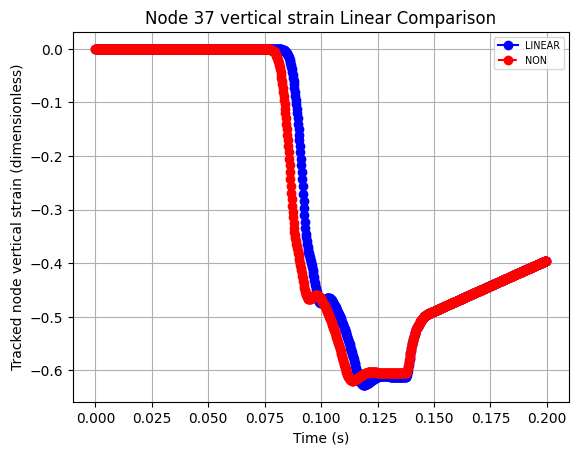

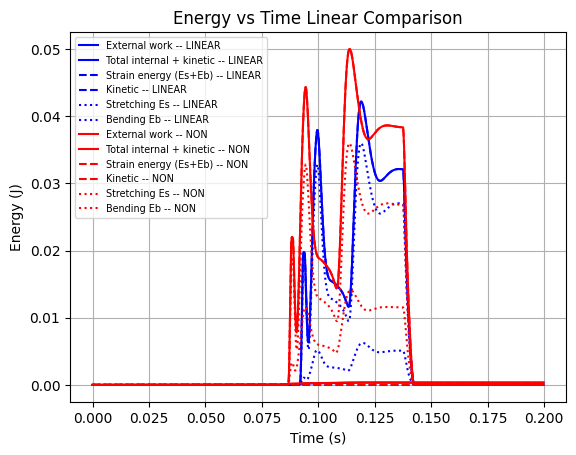

In [ ]:
# Tracked node strain history
if PLOT_CENTER_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(7)
    plt.clf()
    plt.plot(t_arr, all_pos, 'bo-', label='LINEAR')
    plt.plot(t_arr, all_pos1, 'ro--', label='NON')
    plt.xlabel('Time (s)')
    plt.ylabel('Tracked node vertical strain (dimensionless)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.legend(fontsize='x-small')
    plt.title(f'Node {tracked_node} vertical strain Linear Comparison')
    plt.grid(True)
    plt.show()

# Energy vs time
if PLOT_ENERGY_HISTORY:
    t_arr = np.linspace(0.0, ctime, Nsteps)
    plt.figure(8)
    plt.clf()
    plt.plot(t_arr, all_Eext,   'b-',      label='External work -- LINEAR')
    plt.plot(t_arr, all_Etot,   'b-',      label='Total internal + kinetic -- LINEAR')
    plt.plot(t_arr, all_Estrain,   'b--', label='Strain energy (Es+Eb) -- LINEAR')
    plt.plot(t_arr, all_Ek,        'b--', label='Kinetic -- LINEAR')
    plt.plot(t_arr, all_Es,        'b:',  label='Stretching Es -- LINEAR')
    plt.plot(t_arr, all_Eb,        'b:',  label='Bending Eb -- LINEAR')
    plt.plot(t_arr, all_Eext1,   'r-',      label='External work -- NON')
    plt.plot(t_arr, all_Etot1,   'r-',      label='Total internal + kinetic -- NON')
    plt.plot(t_arr, all_Estrain1,   'r--', label='Strain energy (Es+Eb) -- NON')
    plt.plot(t_arr, all_Ek1,        'r--', label='Kinetic -- NON')
    plt.plot(t_arr, all_Es1,        'r:',  label='Stretching Es -- NON')
    plt.plot(t_arr, all_Eb1,        'r:',  label='Bending Eb -- NON')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    mode = "Nonlinear Es" if USE_NONLINEAR_ES else "Linear Es"
    plt.title(f'Energy vs Time Linear Comparison')
    plt.legend(fontsize='x-small')
    plt.grid(True)
    plt.show()